# Dogs vs Cats

# Preprocessing

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [48]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.13.0
True


## Функции загрузки данных

In [98]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data2/train/*.jpg')
test_files = glob('data2/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32, target_size=IMG_SIZE):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path, target_size) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files, target_size=IMG_SIZE):
    while True:
        for path in files:
            yield np.array([load_image(path, target_size)])

In [60]:
[test_path + '/' + x for x in os.listdir(test_path)][0]

'data4/test/12065.jpg'

In [62]:
fit_generator(test_files[0])

<generator object fit_generator at 0x7cab6aac17e0>

## Визуализируем примеры для обучения

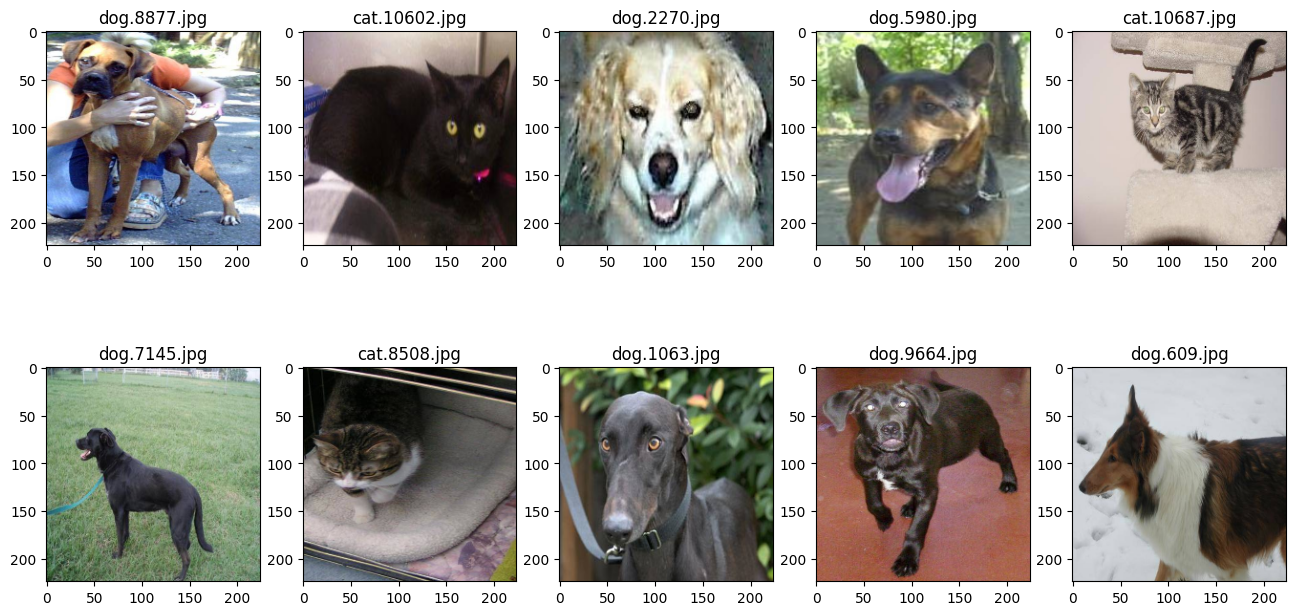

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

# Transfer leraning

## Загружаем предобученную модель

In [15]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [17]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [18]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [29]:
from keras.src.callbacks import LearningRateScheduler, ModelCheckpoint

val_samples = 50  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = fit_generator(train_files[:val_samples])
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

checkpoint = ModelCheckpoint('models6/model{epoch:08d}--{val_accuracy:.2f}.h5',
                             monitor='loss',
                             verbose=1,
                             mode='min',
                             save_best_only=True,
                             save_freq='epoch')

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=35,  # число вызовов генератора за эпоху
          batch_size=32,
          callbacks=[checkpoint],
          epochs=20,  # число эпох обучения
          validation_data=validation_data)


Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9411 
Epoch 1: loss improved from inf to 0.15471, saving model to models6/model00000001--0.80.h5
35/35 [==============================] - 644s 18s/step - loss: 0.1547 - accuracy: 0.9411 - val_loss: 0.2414 - val_accuracy: 0.8000
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9446 
Epoch 2: loss improved from 0.15471 to 0.15278, saving model to models6/model00000002--0.80.h5
35/35 [==============================] - 643s 18s/step - loss: 0.1528 - accuracy: 0.9446 - val_loss: 0.1539 - val_accuracy: 0.8000
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9464 
Epoch 3: loss did not improve from 0.15278
35/35 [==============================] - 639s 18s/step - loss: 0.1582 - accuracy: 0.9464 - val_loss: 0.3732 - val_accuracy: 0.8000
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9161

In [30]:
model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [31]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 6989s 559ms/step


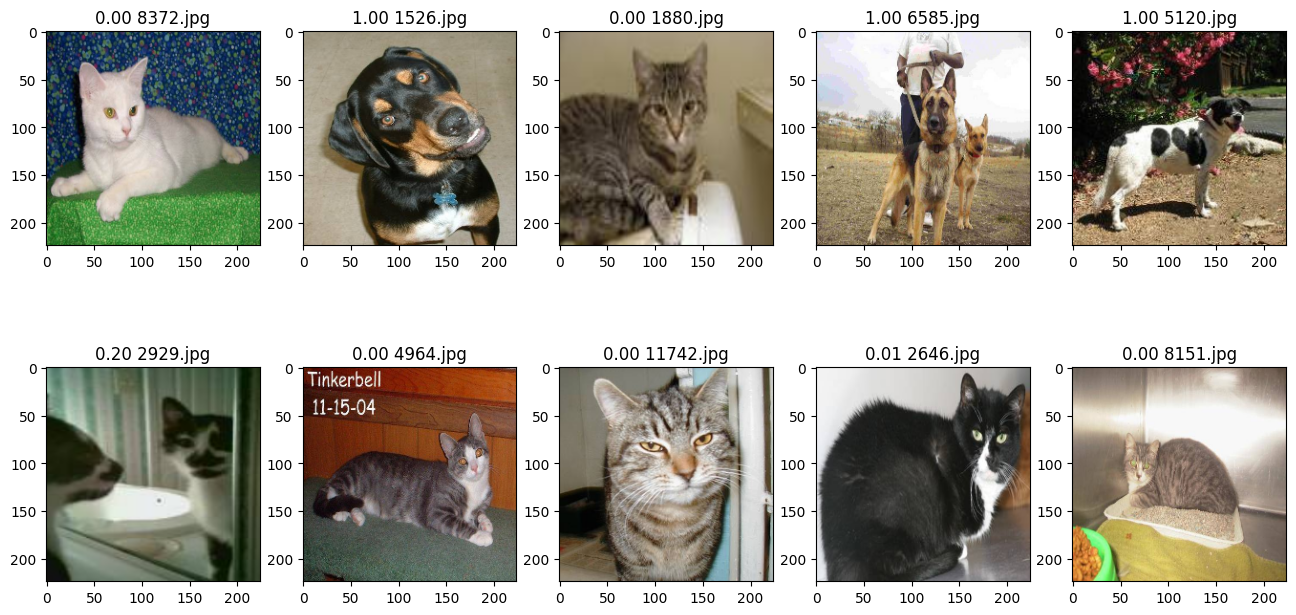

In [32]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [41]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
# LogLoss = 0.14

# CNN


In [1]:
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = "iliagrishchenko"
os.environ['KAGGLE_KEY'] = "9952411365a5ff6a67812d5d5aaa9c18"

!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 801M/814M [00:12<00:00, 97.6MB/s]
100% 814M/814M [00:12<00:00, 67.0MB/s]


In [25]:
import zipfile

data_path = 'data4'
train_path = '{}/train'.format(data_path)
test_path = '{}/test'.format(data_path)

with zipfile.ZipFile('dogs-vs-cats-redux-kernels-edition.zip', 'r') as zipp:
    zipp.extractall(data_path)

with zipfile.ZipFile(data_path + '/test.zip', 'r') as zipp:
    zipp.extractall(data_path)

with zipfile.ZipFile(data_path + '/train.zip', 'r') as zipp:
    zipp.extractall(data_path)

In [29]:
import os
import shutil

new_train_path = data_path + '/processed_train'
if not os.path.exists(new_train_path + '/dog'):
  os.makedirs(new_train_path + '/dog')
if not os.path.exists(new_train_path + '/cat'):
  os.makedirs(new_train_path + '/cat')



for filename in os.listdir(train_path):
  if (filename.split('.')[0] == 'dog'):
    shutil.move('{}/{}'.format(train_path, filename),
                '{}/dog/{}'.format(new_train_path, filename))
  elif (filename.split('.')[0] == 'cat'):
    shutil.move('{}/{}'.format(train_path, filename),
                '{}/cat/{}'.format(new_train_path, filename))

train_path = new_train_path

In [31]:
train_path = new_train_path

In [35]:
img_size = 300

# для обучайющей выборки проводим Аугментацию
bottleneck_datagen = ImageDataGenerator(rescale=1./255,
                                        zca_whitening=True,
                                        rotation_range=10,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        shear_range=0.1,
                                        vertical_flip=True,
                                        validation_split=0.2)

train_ds = bottleneck_datagen.flow_from_directory(train_path,
                                                  batch_size=32,
                                                  shuffle=True,
                                                  subset="training",
                                                  target_size=(img_size,img_size))

valid_ds = bottleneck_datagen.flow_from_directory(train_path,
                                            batch_size=32,
                                            shuffle=True,
                                            subset="validation",
                                            target_size=(img_size,img_size))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [36]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (img_size,img_size,3)),
    MaxPooling2D((2,2)),
    Dropout(0.05),
    BatchNormalization(),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.08),
    BatchNormalization(),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),
    BatchNormalization(),

    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 64)        0

In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
from keras.src.callbacks import LearningRateScheduler, ModelCheckpoint

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr / 5

# Динамическое изменение lr
learning_rate = LearningRateScheduler(scheduler)

In [39]:
checkpoint = ModelCheckpoint('models2/model{epoch:08d}--{val_accuracy:.2f}.h5',
                             monitor='loss',
                             verbose=1,
                             mode='min',
                             save_best_only=True,
                             save_freq='epoch')

In [41]:
cat_dog = model.fit(train_ds,
                    validation_data=valid_ds,
                    callbacks=[checkpoint, learning_rate],
                    steps_per_epoch=35,
                    epochs = 40
                   )

3/3 [==============================] - ETA: 0s - loss: 1.2834 - accuracy: 0.5000 
Epoch 1: loss improved from inf to 1.28340, saving model to models2/model00000001--0.50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 527s 256s/step - loss: 1.2834 - accuracy: 0.5000 - val_loss: 0.9573 - val_accuracy: 0.5000 - lr: 0.0010


In [ ]:
model.save('cats-dogs.hdf5')

In [101]:
test_pred = model.predict(predict_generator(glob(test_path + '/*.jpg'), (img_size, img_size)))

In [ ]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(glob(test_path + '/*.jpg'), test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

# Выводы

Есть какие-нибудь ссылки на применение идей высказанных в лекции?
1. Применение PCA Whitening в моделях
2. Инициализация весов нормалным или равномерным распределением
4. gradient checkpointing

Такие темы мельком расмотрели в лекции, но интересно было бы почитать подробнее и по возможности посмотреть как это реализуется на практике